In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

### Load Data

In [2]:
# Numenta Anomaly Benchmark(NAB) dataset

master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates = True, index_col = "timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates = True, index_col = "timestamp"
)

### Visualize the Data

In [3]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [4]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


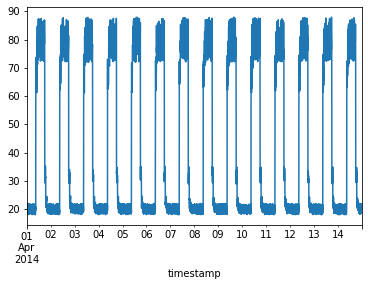

In [5]:
# Timeseries data without anomalies

fig, ax = plt.subplots()
df_small_noise.plot(legend = False, ax = ax)
plt.show()

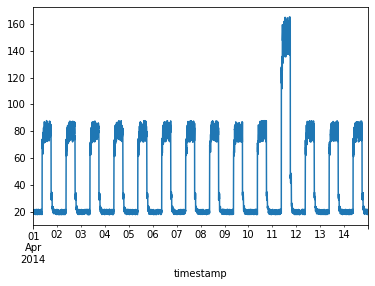

In [6]:
# Timeseries data with anomalies

fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend = False, ax = ax)
plt.show()

### Prep Data

In [7]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [8]:
# We have a value for every 5 mins for 14 days

TIME_STEPS = 288

# Generate training sequences for use in the model

def create_sequences(values, time_steps = TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


### Build Model

We will build a convolutional reconstruction autoencoder model. The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape.

In [9]:
model = keras.Sequential(
    [
        layers.Input(shape = (x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters = 32, kernel_size = 7, padding = "same", strides = 2, activation = "relu"
        ),
        layers.Dropout(rate = 0.2),
        layers.Conv1D(
            filters = 16, kernel_size = 7, padding = "same", strides = 2, activation = "relu"
        ),
        layers.Conv1DTranspose(
            filters = 16, kernel_size = 7, padding = "same", strides = 2, activation = "relu"
        ),
        layers.Dropout(rate = 0.2),
        layers.Conv1DTranspose(
            filters = 32, kernel_size = 7, padding = "same", strides = 2, activation = "relu"
        ),
        layers.Conv1DTranspose(filters = 1, kernel_size = 7, padding = "same"),
    ]
)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = "mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

### Train

In [10]:
history = model.fit(
    x_train,
    x_train,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
    ],
)

Epoch 1/50
27/27 [==============================] - 0s 15ms/step - loss: 0.5463 - val_loss: 0.1034
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0827 - val_loss: 0.0400
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0584 - val_loss: 0.0341
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0496 - val_loss: 0.0299
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0430 - val_loss: 0.0277
Epoch 6/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0385 - val_loss: 0.0258
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0348 - val_loss: 0.0258
Epoch 8/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0323 - val_loss: 0.0235
Epoch 9/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0300 - val_loss: 0.0235
Epoch 10/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 0.0237
Epoch 11/50
27/27 

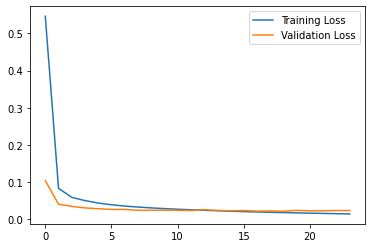

In [11]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

### Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

- Find MAE loss on training samples.
- Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
- If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

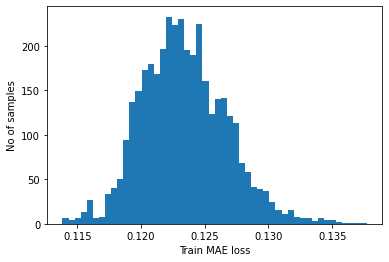

Reconstruction error threshold:  0.137715420373161


In [12]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)

plt.hist(train_mae_loss, bins = 50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

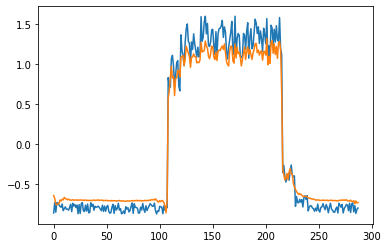

In [13]:
# Reconstruct

plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()